In [1]:
import numpy as np
import os
from pathlib import Path
import torch

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# PATH AND BASIC CONFIG

In [2]:
# Setting the root directory for data
ROOT_DATA_DIR = Path("/Volumes/Data_Bravo/Google_research_open_contrail")
TRAIN_DATA_DIR = ROOT_DATA_DIR / "train"
TEST_DATA_DIR = ROOT_DATA_DIR / "validation"

# Setting random seed for reproducibility
SEED = 19
torch.manual_seed(SEED)
np.random.seed(SEED)

# Setting MPS device to accelerate training
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    print("✅ MPS device available, using it for training.")
else:
    print("❌ MPS device not available, using CPU.")

✅ MPS device available, using it for training.


# DATA PREPROCESSING

In [3]:
# ============================
# 数据预处理和图像生成工具函数
# ============================

# 温度范围常量定义 - 用于卫星图像数据的归一化
# 这些范围基于卫星图像中各波段的物理特性和经验值
_T11_BOUNDS = (243, 303)  # Band 11 温度范围 (Kelvin)，用于蓝色通道
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)  # Band 14-11 温度差范围，用于绿色通道，帮助识别云顶特征
_TDIFF_BOUNDS = (-4, 2)  # Band 15-14 温度差范围，用于红色通道，帮助区分不同类型的云和飞机尾迹

def get_band_images(idx: str, parrent_folder: str, band: str) -> np.array:
    """
    从指定路径加载卫星图像的单个波段数据
    
    Args:
        idx (str): 样本ID，对应文件夹名称
        parrent_folder (str): 父级文件夹名称 ('train' 或 'validation')
        band (str): 波段编号 ('11', '14', '15' 等)
    
    Returns:
        np.array: 加载的波段数据，形状通常为 (height, width, time_frames)
    """
    return np.load(
        os.path.join(ROOT_DATA_DIR, parrent_folder, idx, f'band_{band}.npy')
    )

def normalize_range(data, bounds):
    """
    将数据归一化到 [0, 1] 范围内
    
    为什么需要归一化：
    1. 不同波段的数值范围差异很大，归一化后便于模型学习
    2. 有助于梯度下降的稳定性和收敛速度
    3. 防止某些特征因数值过大而主导模型学习过程
    4. 使得RGB图像的每个通道都在合理的显示范围内
    
    Args:
        data: 输入数据数组
        bounds: 数据的 (最小值, 最大值) 元组
    
    Returns:
        归一化后的数据，范围 [0, 1]
    
    注意：超出bounds范围的值会被映射到 <0 或 >1，通常配合 np.clip 使用
    """
    return (data - bounds[0]) / (bounds[1] - bounds[0])


def get_ash_color_images(
    idx: str, parrent_folder: str, get_mask_frame_only=False
) -> np.array:
    """
    生成假彩色合成图像用于飞机尾迹检测
    
    这个函数创建了一个专门用于检测飞机尾迹的RGB假彩色图像：
    - 红色通道 (R): Band 15-14 温度差，突出显示不同高度的云层差异
    - 绿色通道 (G): Band 14-11 温度差，帮助识别云顶温度特征
    - 蓝色通道 (B): Band 14 绝对温度，提供基础温度信息
    
    为什么使用假彩色：
    1. 人眼无法直接观察红外波段，假彩色将不可见信息转换为可见信息
    2. 温度差异比绝对温度更能突出飞机尾迹的特征
    3. 多波段组合能够增强目标与背景的对比度
    
    Args:
        idx (str): 样本ID
        parrent_folder (str): 数据文件夹 ('train' 或 'validation')
        get_mask_frame_only (bool): 是否只获取mask对应的时间帧 (第4帧，索引为4)
    
    Returns:
        np.array: RGB假彩色图像，形状为 (height, width, 3) 或 (height, width, time_frames, 3)
                 数值范围 [0, 1]
    """
    # 加载三个关键的红外波段
    band11 = get_band_images(idx, parrent_folder, '11')  # 8.6 μm 波段
    band14 = get_band_images(idx, parrent_folder, '14')  # 11.2 μm 波段  
    band15 = get_band_images(idx, parrent_folder, '15')  # 12.4 μm 波段

    # 如果只需要mask对应的时间帧，则提取第4帧
    if get_mask_frame_only:
        band11 = band11[:, :, 4]
        band14 = band14[:, :, 4] 
        band15 = band15[:, :, 4]

    # 计算假彩色通道
    # 红色：Band 15-14 差值，用于检测冰晶云的特征
    r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
    # 绿色：Band 14-11 差值，用于检测云顶高度和温度特征
    g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    # 蓝色：Band 14 绝对温度，提供基础热辐射信息
    b = normalize_range(band14, _T11_BOUNDS)
    
    # 将三个通道合并为RGB图像，并限制在 [0,1] 范围内
    false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
    return false_color

def get_mask_image(idx: str, parrent_folder: str) -> np.array:
    """
    加载人工标注的像素级掩码
    
    Args:
        idx (str): 样本ID
        parrent_folder (str): 数据文件夹
    
    Returns:
        np.array: 二值掩码，1表示飞机尾迹像素，0表示背景像素
                 形状通常为 (height, width, time_frames)
    """
    return np.load(
        os.path.join(ROOT_DATA_DIR, parrent_folder, idx, 'human_pixel_masks.npy')
    )

# MODEL SETUP

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

from torchsummary import summary

# ===========================
# U-Net with a Powerful Pre-trained Backbone
# ===========================
# We are replacing the manually-defined AttentionUNet with smp.Unet.
# This allows us to easily use strong encoders like 'timm-resnest50d'.

# Key Parameters explained:
# - encoder_name: The backbone to use. 'timm-resnest50d' is a strong choice used in high-scoring solutions.
# - encoder_weights: 'imagenet' loads pre-trained weights, which is crucial for good performance.
# - in_channels: Must be 24 to match your dataset's 8 time frames * 3 channels.
# - classes: 1, as we are predicting a single binary mask for contrails.
# - attention_type: 'scse'. This adds an attention mechanism similar to your original AttentionUNet,
#                   maintaining the core idea of focusing on important features.

model = smp.Unet(
    encoder_name="se_resnet101",  # A strong backbone
    encoder_weights="imagenet",  # Use pre-trained weights
    in_channels=24,  # Your specific input channels
    classes=1,  # Output is a single mask
)

In [ ]:
# 创建模型并将其移动到MPS设备
model = model()

summary(model, input_size=(24, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]          13,888
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

# TRAINNER

In [6]:
# ============================
# 损失函数定义
# ============================

class Dice(nn.Module):
    """
    Dice系数（Sørensen-Dice系数）- 语义分割中的重要评估指标
    
    Dice系数公式：Dice = 2×|A∩B| / (|A| + |B|)
    其中：
    - A: 预测的正例像素集合
    - B: 真实的正例像素集合  
    - |A∩B|: 预测和真实都为正例的像素数量（真正例）
    - |A|: 预测为正例的像素总数
    - |B|: 真实正例的像素总数
    
    为什么使用Dice系数：
    1. 类别不平衡处理：飞机尾迹像素通常只占图像的很小部分，Dice系数对正例更敏感
    2. 重叠度量：直接衡量预测区域与真实区域的重叠程度，符合分割任务的评估需求
    3. 可微分：可以作为损失函数进行反向传播训练
    4. 范围 [0,1]：1表示完美重叠，0表示完全不重叠
    
    与其他指标的比较：
    - 准确率 (Accuracy): 在极不平衡数据中容易被背景像素主导
    - IoU (Intersection over Union): 与Dice相关，但Dice对小目标更友好
    - 交叉熵损失: 逐像素计算，不考虑区域的连通性
    
    Args:
        use_sigmoid (bool): 是否对输入应用sigmoid激活
                           True: 输入为logits，需要转换为概率
                           False: 输入已经是概率值
    """
    def __init__(self, use_sigmoid=True):
        super(Dice, self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.use_sigmoid = use_sigmoid

    def forward(self, inputs, targets, smooth=1):
        """
        计算Dice系数
        
        Args:
            inputs: 模型预测输出 (batch_size, 1, H, W)
                   如果use_sigmoid=True，则为logits；否则为概率
            targets: 真实标签 (batch_size, 1, H, W)，二值掩码，0或1
            smooth: 平滑常数，防止分母为0，提高数值稳定性
                   较小的smooth值使得Dice对小目标更敏感
        
        Returns:
            dice: Dice系数，范围 [0, 1]
        
        计算细节：
        1. 将多维张量展平为一维，便于计算交集和并集
        2. 计算intersection：预测和真实都为正的像素数量
        3. 应用Dice公式，加入平滑项避免除零错误
        """
        # 如果输入是logits，转换为概率
        if self.use_sigmoid:
            inputs = self.sigmoid(inputs)

        # 将张量展平为一维向量，便于计算像素级的交集
        # 原始形状：(batch_size, 1, H, W) -> 展平后：(batch_size * H * W)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # 计算交集：预测为正且真实为正的像素数量
        # inputs * targets: 逐元素相乘，只有都为1时结果才为1
        intersection = (inputs * targets).sum()
        
        # 应用Dice公式
        # 分子：2 * 交集 + 平滑项
        # 分母：预测正例总数 + 真实正例总数 + 平滑项
        dice = (2.0 * intersection + smooth) / (
            inputs.sum() + targets.sum() + smooth
        )

        return dice


# 实例化Dice评估器
# 注意：这里创建的是评估指标，不是损失函数
# 训练时通常使用 1 - Dice 作为损失函数，或使用专门的DiceLoss
dice = Dice()

In [7]:
class FocalLoss(nn.Module):
    """
    Focal Loss - 旨在解决类别不平衡问题
    
    相较于BCEWithLogitsLoss的优势：
    1. 动态缩放损失：通过调制因子(1-pt)^gamma，降低了易于分类样本的权重。
       - 当一个像素被高概率(pt -> 1)正确分类时，其对损失的贡献会变得非常小。
       - 这使得模型可以更专注于那些难以分类的样本（例如，模糊的航迹边缘）。
    2. 处理类别数量不平衡：通过alpha参数（类似于pos_weight）平衡正负样本的重要性。

    参数：
        alpha (float): 正样本的权重，用于平衡正负样本。范围 [0, 1]。
        gamma (float): 聚焦参数。gamma > 0 会降低易分类样本的损失贡献。通常取值为2。
    """
    def __init__(self, alpha=0.25, gamma=2.0, pos_weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        # 使用BCEWithLogitsLoss作为基础，因为它在数值上更稳定
        self.bce_with_logits = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='none')

    def forward(self, inputs, targets):
        # 计算基础的BCE损失，不进行聚合
        bce_loss = self.bce_with_logits(inputs, targets)
        
        # 计算预测概率
        p_t = torch.exp(-bce_loss)
        
        # 计算Focal Loss的调制因子
        modulating_factor = (1 - p_t) ** self.gamma
        
        # 计算alpha权重
        alpha_weight = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        
        # 计算最终的Focal Loss
        focal_loss = alpha_weight * modulating_factor * bce_loss
        
        return focal_loss.mean()


In [ ]:
import os
from torch.amp import autocast

torch.set_autocast_enabled(True)

# ============================
# 模型训练器类
# ============================


class MyTrainer:
    """
    自定义训练器类 - 封装深度学习模型的训练和验证流程

    功能特性：
    1. 训练循环管理：自动化epoch和batch的迭代
    2. 损失记录：跟踪训练和验证损失的变化趋势
    3. 学习率调度：支持动态学习率调整
    4. 模型检查点：定期保存模型状态
    5. 验证评估：定期在验证集上评估模型性能
    6. [新增] 混合精度训练：通过 torch.amp 支持 AMP，加速训练并减少显存占用

    设计模式：
    - 将训练逻辑与模型定义分离，提高代码可维护性
    - 支持不同的优化器、损失函数和学习率调度器
    - 自动处理GPU/CPU设备切换
    """

    def __init__(
        self,
        model,
        optimizer,
        loss_fn,
        lr_scheduler,
        device,
        use_amp: bool = True,
    ):
        """
        初始化训练器

        Args:
            model: 待训练的神经网络模型
            optimizer: 优化器 (如Adam, SGD等)
            loss_fn: 损失函数 (如BCEWithLogitsLoss, CrossEntropyLoss等)
            lr_scheduler: 学习率调度器 (如ExponentialLR, StepLR等)
            device: 训练设备 (例如, torch.device('mps'))
            use_amp (bool): 是否启用自动混合精度 (AMP)
        """
        # 训练历史记录
        self.validation_losses = []  # 验证集损失历史
        self.batch_losses = []  # 所有batch损失历史
        self.epoch_losses = []  # 每个epoch平均损失
        self.learning_rates = []  # 学习率变化历史

        # 训练组件
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.use_amp = use_amp

        # 将模型移动到指定设备
        self.model.to(self.device)

        print(
            f"训练器初始化完成。设备: {self.device}, 自动混合精度(AMP): {'启用' if self.use_amp else '禁用'}"
        )
        print(
            "🔴 mps 设备的梯度缩放 GridScaler 功能有问题会导致数据精度不一致报错，所以这里只用了AMP，小心梯度溢出！"
        )

        # 验证优化器和模型的参数是否匹配
        self._check_optim_net_aligned()

    def _check_optim_net_aligned(self):
        """
        验证优化器是否正确绑定到模型参数
        """
        assert self.optimizer.param_groups[0]['params'] == list(
            self.model.parameters()
        ), "优化器参数与模型参数不匹配！"

    def fit(
        self,
        train_dataloader: DataLoader,
        test_dataloader: DataLoader,
        epochs: int = 10,
        eval_every: int = 1,
    ):
        """
        模型训练主循环
        """
        for e in range(epochs):
            print(f"=== Epoch {e+1}/{epochs} ===")
            print(f"当前学习率: {self.lr_scheduler.get_last_lr()}")
            self.learning_rates.append(self.lr_scheduler.get_last_lr()[0])

            batch_losses, sub_batch_losses = [], []

            # ========================
            # 训练阶段 (Training Phase)
            # ========================
            self.model.train()  # 设置模型为训练模式
            for i, data in enumerate(train_dataloader):

                # (修正) 将进度显示逻辑调整为 (i+1)，避免跳过第0个batch
                if (i + 1) % 100 == 0:
                    avg_loss = (
                        torch.Tensor(sub_batch_losses).mean()
                        if sub_batch_losses
                        else 0
                    )
                    print(
                        f' 训练 Batch {i+1:4d}/{len(train_dataloader)} | 平均损失: {avg_loss:.6f}'
                    )
                    sub_batch_losses.clear()

                images, mask = data
                images = images.to(self.device)
                mask = mask.to(self.device)

                self.optimizer.zero_grad()

                # === AMP 前向传播 (修改) ===
                # autocast 上下文管理器会自动为不同op选择合适的精度(float16或float32)。
                # `device_type` 应与你的设备匹配 ('mps', 'cuda', 'cpu')。
                # 参考文档: https://pytorch.org/docs/stable/amp.html#autocasting
                with torch.autocast(
                    device_type='mps',
                    dtype=torch.bfloat16,
                    enabled=self.use_amp,
                ):
                    outputs = self.model(images)
                    loss = self.loss_fn(outputs, mask)

                # 后向传播
                loss.backward()
                # 优化器往后传播梯度并更新参数
                self.optimizer.step()

                loss_item = loss.item()
                self.batch_losses.append(loss_item)
                batch_losses.append(loss_item)
                sub_batch_losses.append(loss_item)

            if self.lr_scheduler is not None:
                self.lr_scheduler.step()

            mean_epoch_loss = torch.Tensor(batch_losses).mean().item()
            self.epoch_losses.append(mean_epoch_loss)
            print(f'  训练损失: {mean_epoch_loss:.6f}')

            # ========================
            # 验证阶段 (Validation Phase)
            # ========================
            if (e + 1) % eval_every == 0:
                os.makedirs("checkpoints_attention", exist_ok=True)
                checkpoint_path = f"checkpoints_attention/model_checkpoint_e{e+1}.pt"
                torch.save(self.model.state_dict(), checkpoint_path)
                print(f"  模型已保存: {checkpoint_path}")

                with torch.no_grad():
                    self.model.eval()  # 设置模型为评估模式
                    validation_losses = []
                    for i, data in enumerate(test_dataloader):
                        images, mask = data
                        images = images.to(self.device)
                        mask = mask.to(self.device)

                        # === AMP 验证前向传播 (修改) ===
                        # 在验证阶段也使用 autocast，以获得性能提升并确保与训练时行为一致。
                        with autocast(
                            device_type=self.device.type,
                            dtype=torch.float16,
                            enabled=self.use_amp,
                        ):
                            output = self.model(images)
                            loss = self.loss_fn(output, mask)

                        validation_losses.append(loss.item())

                    avg_val_loss = torch.Tensor(validation_losses).mean().item()
                    self.validation_losses.append(avg_val_loss)
                    print(f"  验证损失: {avg_val_loss:.6f}")

                    if len(self.validation_losses) > 1:
                        if (
                            self.validation_losses[-1]
                            < self.validation_losses[-2]
                        ):
                            print("  ✅ 验证损失下降")
                        else:
                            print("  ⚠️ 验证损失上升")

            print()

# DATASET

In [9]:
import pandas as pd

# ============================
# 自定义数据集类
# ============================

class ContrailsAshDataset(torch.utils.data.Dataset):
    """
    飞机尾迹检测数据集类 - 继承自PyTorch Dataset基类
    
    数据集结构：
    - 每个样本包含多个时间帧的卫星图像数据
    - 输入：24通道假彩色图像序列 (8个时间帧 × 3个RGB通道)
    - 输出：像素级二值掩码 (8个时间帧的标注)
    
    数据预处理流程：
    1. 加载多波段卫星图像 (band_11, band_14, band_15)
    2. 计算假彩色合成图像
    3. 加载人工标注的像素掩码
    4. 张量转换和维度调整
    5. 数据类型转换 (float32)
    
    设计考虑：
    - 延迟加载：只在需要时才从磁盘读取数据，节省内存
    - 灵活的数据变换：支持训练时的数据增强
    - 批处理友好：输出格式适合DataLoader批处理
    """
    
    def __init__(self, parrent_folder: str):
        """
        初始化数据集
        
        Args:
            parrent_folder (str): 数据文件夹名称，'train' 或 'validation'
                                 对应 ROOT_DATA_DIR/train 或 ROOT_DATA_DIR/validation
        
        数据集组织结构：
        ROOT_DATA_DIR/
        ├── train/
        │   ├── sample_001/
        │   │   ├── band_11.npy    # 8.6μm 红外波段数据
        │   │   ├── band_14.npy    # 11.2μm 红外波段数据  
        │   │   ├── band_15.npy    # 12.4μm 红外波段数据
        │   │   └── human_pixel_masks.npy  # 人工标注掩码
        │   └── sample_002/
        │       └── ...
        └── validation/
            └── ...
        """
        # 获取数据文件夹路径
        data_folder_path = os.path.join(ROOT_DATA_DIR, parrent_folder)
        
        # 获取所有文件和文件夹
        all_items = os.listdir(data_folder_path)
        
        # 只保留文件夹，过滤掉文件
        sample_ids = [
            item for item in all_items 
            if os.path.isdir(os.path.join(data_folder_path, item))
        ]
        
        # 创建DataFrame存储样本索引，便于后续查找和管理
        self.df_idx: pd.DataFrame = pd.DataFrame({'idx': sample_ids})
        self.parrent_folder: str = parrent_folder
        
        print(f"📊 {parrent_folder} 数据集初始化完成:")
        print(f"   样本数量: {len(sample_ids)}")
        print(f"   数据路径: {data_folder_path}")

    def __len__(self):
        """
        返回数据集大小
        
        PyTorch Dataset必须实现的方法之一
        用于DataLoader确定数据集的总样本数
        """
        return len(self.df_idx)

    def __getitem__(self, idx):
        """
        根据索引获取单个样本
        
        PyTorch Dataset必须实现的方法之一
        支持索引访问: dataset[0], dataset[1], ...
        
        Args:
            idx (int): 样本索引，范围 [0, len(dataset)-1]
            
        Returns:
            tuple: (images, mask)
                - images: 输入图像张量 (24, 256, 256) 
                         24通道 = 8个时间帧 × 3个RGB通道
                - mask: 标签掩码张量 (8, 256, 256)
                       每个时间帧对应一个二值掩码
        
        数据变换过程：
        1. 获取样本ID
        2. 加载假彩色图像 (256, 256, 8, 3)
        3. 重塑为 (256, 256, 24) - 将时间和通道维度合并
        4. 转换为PyTorch张量并调整维度顺序为 (C, H, W)
        5. 加载掩码数据并进行相同的张量转换
        """
        # 根据索引获取样本ID
        image_id: str = str(self.df_idx.iloc[idx]['idx'])
        
        # 加载假彩色图像数据
        # get_mask_frame_only=False: 加载所有8个时间帧
        # 返回形状: (height=256, width=256, time_frames=8, rgb_channels=3)
        ash_color_images = get_ash_color_images(
            image_id, self.parrent_folder, get_mask_frame_only=False
        )
        
        # 重塑图像数据：将时间帧和RGB通道合并
        # (256, 256, 8, 3) -> (256, 256, 24)
        # 这样做的原因：
        # 1. U-Net期望固定的输入通道数
        # 2. 将时序信息编码为多通道特征
        # 3. 简化网络结构，避免处理时序维度
        reshaped_images = np.reshape(ash_color_images, (256, 256, 24))
        
        # 转换为PyTorch张量并调整维度
        # numpy: (H, W, C) -> torch: (C, H, W)
        # 原因：PyTorch卷积层期望通道优先的格式
        images = (
            torch.tensor(reshaped_images)
            .to(torch.float32)           # 确保数据类型为float32
            .permute(2, 0, 1)           # (H, W, C) -> (C, H, W)
        )
        
        # 加载标签掩码
        mask_data = get_mask_image(image_id, self.parrent_folder)
        
        # 转换掩码为PyTorch张量
        # 形状: (H, W, T) -> (T, H, W) 其中T是时间帧数
        mask = (
            torch.tensor(mask_data)
            .to(torch.float32)           # BCEWithLogitsLoss需要float类型
            .permute(2, 0, 1)           # (H, W, T) -> (T, H, W)
        )
        
        return images, mask

In [10]:
# ============================
# 优化版数据加载器配置
# ============================

# 创建训练和验证数据集实例
print("🔄 正在初始化数据集...")
dataset_train = ContrailsAshDataset('train')
dataset_validation = ContrailsAshDataset('validation')

# ========================
# 数据加载器优化配置
# ========================
# 配置数据加载器参数
BATCH_SIZE = 16        # 稍微增加批大小以提高GPU利用率
SHUFFLE_TRAIN = True   # 训练集随机打乱
SHUFFLE_VAL = False    # 验证集不打乱以保持一致性

print("⚙️ 优化版数据加载器配置:")
print(f"   批大小: {BATCH_SIZE}")
print(f"   训练集打乱: {SHUFFLE_TRAIN}")

# ========================
# 数据加载器性能优化技巧
# ========================

# 创建训练数据加载器
data_loader_train = DataLoader(
    dataset_train, 
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_TRAIN,
    # num_workers=NUM_WORKERS,
    drop_last=True,                 # 保证batch大小一致
    generator=torch.Generator().manual_seed(SEED)  # 确保可重现性
)

# 创建验证数据加载器
data_loader_validation = DataLoader(
    dataset_validation, 
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VAL,
    # num_workers=NUM_WORKERS,
    drop_last=False,                # 验证时保留所有数据
    generator=torch.Generator().manual_seed(SEED)
)

print("✅ 优化版数据加载器创建完成!")
print(f"   训练批次数: {len(data_loader_train)}")
print(f"   验证批次数: {len(data_loader_validation)}")
print(f"   每epoch训练样本: {len(data_loader_train) * BATCH_SIZE}")
print(f"   每epoch验证样本: {len(dataset_validation)}")

🔄 正在初始化数据集...
📊 train 数据集初始化完成:
   样本数量: 20529
   数据路径: /Volumes/Data_Bravo/Google_research_open_contrail/train
📊 validation 数据集初始化完成:
   样本数量: 1856
   数据路径: /Volumes/Data_Bravo/Google_research_open_contrail/validation
⚙️ 优化版数据加载器配置:
   批大小: 16
   训练集打乱: True
✅ 优化版数据加载器创建完成!
   训练批次数: 1283
   验证批次数: 116
   每epoch训练样本: 20528
   每epoch验证样本: 1856

💡 已应用的数据加载优化:
✅ 批大小优化: 平衡内存使用和GPU利用率
✅ 可重现性: 固定随机种子确保结果一致


# TRAIN

In [ ]:
# ============================
# 模型训练配置与执行 - 包含训练加速优化
# ============================

# 训练控制开关
train = True  # True: 从头训练新模型, False: 加载预训练模型

if train:
    print("🚀 开始训练新模型...")

    # ========================
    # 训练加速优化设置
    # ========================
    # 1. 启用编译模式加速 (PyTorch 2.0+)
    torch.backends.cudnn.benchmark = True  # 对固定输入大小启用cuDNN优化

    print("✅ 训练加速优化已启用")
    print("   - cuDNN benchmark: True")

    # ========================
    # 模型初始化
    # ========================
    model = AttentionUNet()
    model.to(mps_device)  # 将模型移动到MPS设备
    print(f"✅ 模型已加载到设备: {mps_device}")

    # ========================
    # 损失函数配置 - 内存优化版本
    # ========================
    # # 使用带权重的二元交叉熵损失 (Binary Cross Entropy with Logits Loss)
    # # 将pos_weight移动到设备上，避免每次forward时的数据传输
    # pos_weight = torch.tensor(100.0, device=mps_device, dtype=torch.float32)
    # criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    # print("📊 损失函数: BCEWithLogitsLoss (pos_weight=100, 设备优化)")

    # 我们用 Focal Loss试试
    # 将pos_weight移动到设备上
    pos_weight = torch.tensor(100.0, device=mps_device, dtype=torch.float32)
    # 实例化 FocalLoss，并传入 alpha, gamma 和 pos_weight
    # 您可以根据实际需求调整 alpha 和 gamma 的值
    criterion = FocalLoss(alpha=0.25, gamma=2.0, pos_weight=pos_weight)
    print(
        f"📊 损失函数: FocalLoss (alpha={criterion.alpha}, gamma={criterion.gamma}, pos_weight={pos_weight.item()}, 设备优化)"
    )

    # ========================
    # 优化器配置 - 性能调优版本
    # ========================
    # Adam优化器配置，添加性能优化参数
    optimizer = optim.AdamW(
        model.parameters(),
        lr=0.01,
        weight_decay=1e-5,  # 添加轻微L2正则化，有助于收敛
    )
    print("🎯 优化器: Adam (性能优化版本)")

    # ========================
    # 学习率调度器 -
    # ========================
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.70)

    # ========================
    # 训练超参数
    # ========================
    num_epochs = 11  # 训练轮次

    # ========================
    # 训练执行 - 增强版训练器
    # ========================
    print("\n" + "=" * 60)
    print("🚀 开始优化训练过程...")
    print("=" * 60)

    trainer = MyTrainer(
        model=model,
        optimizer=optimizer,
        loss_fn=criterion,
        lr_scheduler=lr_scheduler,
        device=mps_device,
        use_amp=True,  # 设置为 True 以启用混合精度
    )

    # 执行优化训练
    trainer.fit(
        train_dataloader=data_loader_train,
        test_dataloader=data_loader_validation,
        epochs=num_epochs,
        eval_every=1,
    )

    print("\n" + "=" * 60)
    print("🎉 优化训练完成！")
    print("=" * 60)

    # 清理内存，后续只用模型推理，不用训练了
    del trainer, model, optimizer, criterion, lr_scheduler
    torch.mps.empty_cache()  # 清理MPS缓存

else:
    # ========================
    # 加载预训练模型
    # ========================
    print("📂 加载预训练模型...")
    model = AttentionUNet()

    model_path = 'checkpoints/model_checkpoint_e11.pt'  # 更新路径
    try:
        model.load_state_dict(torch.load(model_path, map_location='cpu'))
        print(f"✅ 成功加载模型: {model_path}")
    except FileNotFoundError:
        print(f"❌ 模型文件未找到: {model_path}")
        print("请检查文件路径或先运行训练代码")
    except Exception as e:
        print(f"❌ 模型加载失败: {e}")

    model.eval()
    model.to(mps_device)
    print(f"🔍 模型已设置为评估模式并移动到: {mps_device}")

🚀 开始训练新模型...
✅ 训练加速优化已启用
   - cuDNN benchmark: True
✅ 模型已加载到设备: mps
📊 损失函数: BCEWithLogitsLoss (pos_weight=100, 设备优化)
🎯 优化器: Adam (性能优化版本)

🚀 开始优化训练过程...
训练器初始化完成。设备: mps, 自动混合精度(AMP): 启用
=== Epoch 1/11 ===
当前学习率: [0.01]
 训练 Batch  100/1283 | 平均损失: 0.923922
 训练 Batch  200/1283 | 平均损失: 0.822895
 训练 Batch  300/1283 | 平均损失: 0.715918
 训练 Batch  400/1283 | 平均损失: 0.611085
 训练 Batch  500/1283 | 平均损失: 0.576139
 训练 Batch  600/1283 | 平均损失: 0.590421
 训练 Batch  700/1283 | 平均损失: 0.534664
 训练 Batch  800/1283 | 平均损失: 0.499325
 训练 Batch  900/1283 | 平均损失: 0.493333
 训练 Batch 1000/1283 | 平均损失: 0.503496
 训练 Batch 1100/1283 | 平均损失: 0.471070
 训练 Batch 1200/1283 | 平均损失: 0.460321
  训练损失: 0.590844
  模型已保存: checkpoints_attention/model_checkpoint_e1.pt
  验证损失: 0.302245

=== Epoch 2/11 ===
当前学习率: [0.006999999999999999]
 训练 Batch  100/1283 | 平均损失: 0.428232
 训练 Batch  200/1283 | 平均损失: 0.448810
 训练 Batch  300/1283 | 平均损失: 0.441444
 训练 Batch  400/1283 | 平均损失: 0.439249
 训练 Batch  500/1283 | 平均损失: 0.377447
 训练 Batch  60

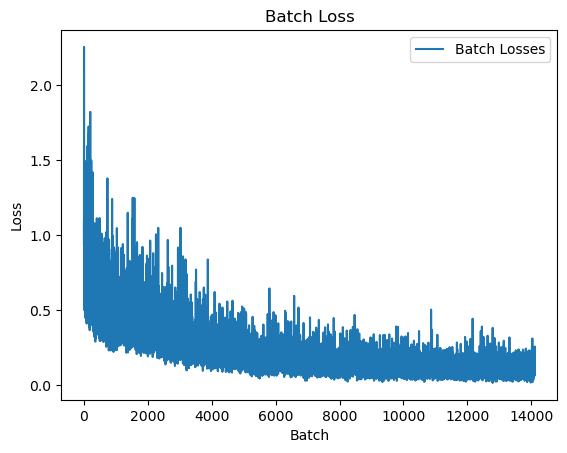

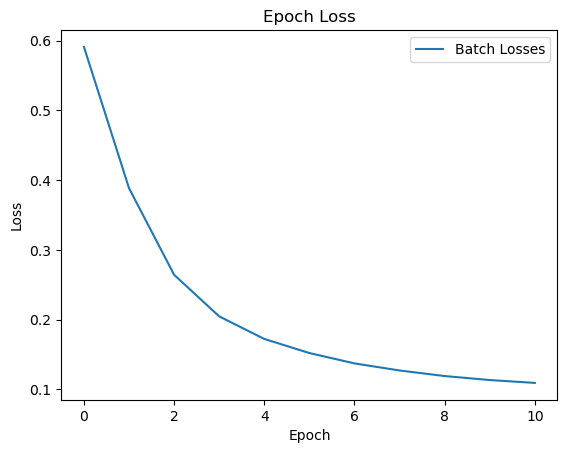

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

if train:
    df_data = pd.DataFrame({'Batch Losses': trainer.batch_losses})
    sns.lineplot(data=df_data)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Batch Loss')
    plt.show()

    df_data = pd.DataFrame({'Batch Losses': trainer.epoch_losses})
    sns.lineplot(data=df_data)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch Loss')
    plt.show()

# FIND OPTIMAL THRESHOLD

In [13]:
from tqdm import tqdm

class DiceThresholdTester:

    def __init__(
        self, model: nn.Module, data_loader: torch.utils.data.DataLoader
    ):
        self.model = model
        self.data_loader = data_loader
        self.cumulative_mask_pred = []
        self.cumulative_mask_true = []

    def precalculate_prediction(self) -> None:
        sigmoid = nn.Sigmoid()

        for images, mask_true in self.data_loader:
            if mps_device:
                images = images.to(mps_device)

            mask_pred = sigmoid(model.forward(images))

            self.cumulative_mask_pred.append(mask_pred.cpu().detach().numpy())
            self.cumulative_mask_true.append(mask_true.cpu().detach().numpy())

        self.cumulative_mask_pred = np.concatenate(
            self.cumulative_mask_pred, axis=0
        )
        self.cumulative_mask_true = np.concatenate(
            self.cumulative_mask_true, axis=0
        )

        self.cumulative_mask_pred = torch.flatten(
            torch.from_numpy(self.cumulative_mask_pred)
        )
        self.cumulative_mask_true = torch.flatten(
            torch.from_numpy(self.cumulative_mask_true)
        )

    def test_threshold(self, threshold: float) -> float:
        _dice = Dice(use_sigmoid=False)
        after_threshold = np.zeros(self.cumulative_mask_pred.shape)
        after_threshold[self.cumulative_mask_pred[:] > threshold] = 1
        after_threshold[self.cumulative_mask_pred[:] < threshold] = 0
        after_threshold = torch.flatten(torch.from_numpy(after_threshold))
        return _dice(self.cumulative_mask_true, after_threshold).item()

# ============================
dice_threshold_tester = DiceThresholdTester(model, data_loader_validation)
dice_threshold_tester.precalculate_prediction()

thresholds_to_test = [round(x * 0.01, 2) for x in range(101)]

optim_threshold = 0.975
best_dice_score = -1

thresholds = []
dice_scores = []

for t in tqdm(thresholds_to_test, desc="Testing thresholds"):
    dice_score = dice_threshold_tester.test_threshold(t)
    if dice_score > best_dice_score:
        best_dice_score = dice_score
        optim_threshold = t

    thresholds.append(t)
    dice_scores.append(dice_score)

print(f'Best Threshold: {optim_threshold} with dice: {best_dice_score}')
df_threshold_data = pd.DataFrame(
    {'Threshold': thresholds, 'Dice Score': dice_scores}
)

Testing thresholds: 100%|██████████| 101/101 [00:32<00:00,  3.12it/s]

Best Threshold: 0.97 with dice: 0.5406840920700806


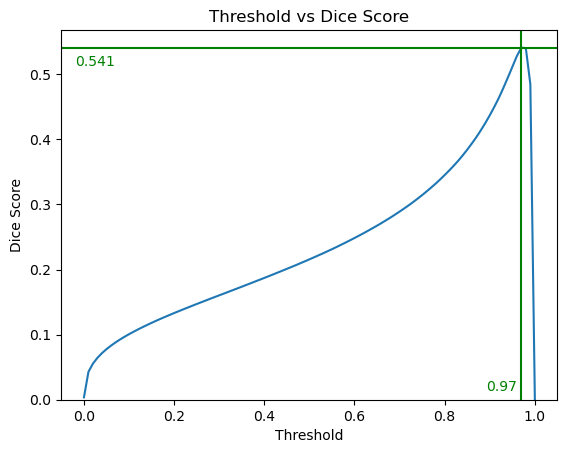

In [14]:
sns.lineplot(data=df_threshold_data, x='Threshold', y='Dice Score')
plt.axhline(y=best_dice_score, color='green')
plt.axvline(x=optim_threshold, color='green')
plt.text(
    -0.02,
    best_dice_score * 0.96,
    f'{best_dice_score:.3f}',
    va='center',
    ha='left',
    color='green',
)
plt.text(
    optim_threshold - 0.01,
    0.02,
    f'{optim_threshold}',
    va='center',
    ha='right',
    color='green',
)
plt.ylim(bottom=0)
plt.title('Threshold vs Dice Score')
plt.show()